[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SMase/lm_signate/blob/main/nb/mushroom/001_mush_folds.ipynb)

In [ ]:
# !nvidia-smi

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cp -R /content/drive/My\ Drive/Colab\ Notebooks/signate/mushroom/data/* .

In [5]:
!pip install shap lime

     |████████████████████████████████| 564 kB 13.0 MB/s 
     |████████████████████████████████| 275 kB 48.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=806a930e64359671e2df5b0fce8756063104566d09ae45bdaa84aa33da79e00a
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [6]:
import shap
import lime
import lightgbm as lgb
import matplotlib.pyplot as plt
import sklearn
from six import StringIO
from sklearn import preprocessing, metrics, model_selection
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer 
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, train_test_split
from sklearn import linear_model

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from datetime import datetime, date, timezone, timedelta
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc

## データ読み込み

In [7]:
train_df = pd.read_csv("./raw/train.tsv", sep="\t")
test_df = pd.read_csv("./raw/test.tsv", sep="\t")
combine = [train_df, test_df]

In [8]:
# 学習データカテゴリ
print(train_df.columns.values)

# どのカテゴリデータ、数値データを利用するか

['id' 'Y' 'cap-shape' 'cap-surface' 'cap-color' 'bruises' 'odor'
 'gill-attachment' 'gill-spacing' 'gill-size' 'gill-color' 'stalk-shape'
 'stalk-root' 'stalk-surface-above-ring' 'stalk-surface-below-ring'
 'stalk-color-above-ring' 'stalk-color-below-ring' 'veil-type'
 'veil-color' 'ring-number' 'ring-type' 'spore-print-color' 'population'
 'habitat']


In [9]:
display(train_df.info())
display(train_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4062 entries, 0 to 4061
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        4062 non-null   int64 
 1   Y                         4062 non-null   object
 2   cap-shape                 4062 non-null   object
 3   cap-surface               4062 non-null   object
 4   cap-color                 4062 non-null   object
 5   bruises                   4062 non-null   object
 6   odor                      4062 non-null   object
 7   gill-attachment           4062 non-null   object
 8   gill-spacing              4062 non-null   object
 9   gill-size                 4062 non-null   object
 10  gill-color                4062 non-null   object
 11  stalk-shape               4062 non-null   object
 12  stalk-root                4062 non-null   object
 13  stalk-surface-above-ring  4062 non-null   object
 14  stalk-surface-below-ring

None

,id,Y,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,p,f,y,n,f,f,f,c,n,b,t,?,s,k,w,w,p,w,o,e,w,v,d
1,2,p,f,y,y,f,f,f,c,b,p,e,b,k,k,b,p,p,w,o,l,h,y,g
2,3,e,b,y,w,t,l,f,c,b,k,e,c,s,s,w,w,p,w,o,p,k,n,m
3,5,p,x,s,b,t,f,f,c,b,h,t,b,s,s,w,w,p,w,o,p,h,v,u
4,7,p,x,s,w,t,f,f,c,b,w,t,b,s,f,w,w,p,w,o,p,h,v,g


In [10]:
display(test_df.info())
display(test_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4062 entries, 0 to 4061
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        4062 non-null   int64 
 1   cap-shape                 4062 non-null   object
 2   cap-surface               4062 non-null   object
 3   cap-color                 4062 non-null   object
 4   bruises                   4062 non-null   object
 5   odor                      4062 non-null   object
 6   gill-attachment           4062 non-null   object
 7   gill-spacing              4062 non-null   object
 8   gill-size                 4062 non-null   object
 9   gill-color                4062 non-null   object
 10  stalk-shape               4062 non-null   object
 11  stalk-root                4062 non-null   object
 12  stalk-surface-above-ring  4062 non-null   object
 13  stalk-surface-below-ring  4062 non-null   object
 14  stalk-color-above-ring  

None

,id,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,x,s,w,t,f,f,c,b,p,t,b,f,f,w,w,p,w,o,p,h,v,g
1,4,f,y,g,t,n,f,c,b,n,t,b,s,s,p,g,p,w,o,p,n,y,d
2,6,x,y,e,t,n,f,c,b,w,t,b,s,s,w,p,p,w,o,p,n,y,d
3,8,f,s,g,t,f,f,c,b,p,t,b,f,s,w,w,p,w,o,p,h,v,g
4,9,x,s,e,f,y,f,c,n,b,t,?,k,s,w,w,p,w,o,e,w,v,l


## データ理解

- cap-shape: 傘形状（ベル型=b, 円錐型=c, 饅頭型=x, 扁平型=f, コブ型=k, 凹んだ扁平型=s） => 名義変数
- cap-surface: 傘表面（繊維=f, 溝=g, 鱗片=y, 滑らか=s） => 名義変数
- cap-color: 傘の色（ブラウン=n, バフ=b, シナモン=c, グレー=g, グリーン=r, ピンク=p, パープル=u, レッド=e, ホワイト=w, イエロー=y） => 名義変数
- bruises: 斑点（斑点あり=t, 斑点なし=f） => 名義変数
- odor: 臭気（アーモンド=a, アニス=l, クレオソート=c, フィッシュ=y, ファウル=f, ミューズイ=m, なし=n, 辛味=p, スパイシー=s） => 名義変数
- gill-attachment: ひだの付き方（直生=a, 垂生=d, 離生=f, 凹生=n） => 名義変数
- gill-spacing: ひだの間隔（近い=c, 過密=w, 長い=d） => 名義変数
- gill-size: ひだのサイズ（広い=b, 狭い=n） => 名義変数
- gill-color: ひだの色（ブラック=k, ブラウン=n, バフ=b, チョコレート=h, グレー=g, グリーン=r, オレンジ=o, ピンク=p, パープル=u, レッド=e, ホワイト=w, イエロー=y） => 名義変数
- stalk-shape: 柄の形状（広がり=e, 先細り=t） => 名義変数
- stalk-root: 柄の根（球根=b, クラブ=c, カップ=u, 等しい=e 根茎形態=z, 根=r, 無し=？） => 名義変数
- stalk-surface-above-ring: 柄表面-上記リング（繊維状=f, 鱗片状=y, 絹毛=k, 滑らか=s） => 名義変数
- stalk-surface-below-ring: 柄-表面下のリング（繊維状=f, 鱗片状=y, 絹毛=k, 滑らか=s） => 名義変数
- stalk-color-above-ring: 柄の色-上記リング（ブラウン=n, バフ=b, シナモン=c, グレー=g, オレンジ=o, ピンク=p, 赤=e, 白=w, 黄色=y） => 名義変数
- stalk-color-below-ring: 柄-カラーリング下（ブラウン=n, バフ=b, シナモン=c, グレー=g, オレンジ=o, ピンク=p, 赤=e, 白=w, 黄色=y） => 名義変数
- veil-type: つぼの種類（内皮膜=p, 外皮膜=u） => 名義変数
- veil-color: つぼの色（ブラウン=n, オレンジ=o, ホワイト=w, イエロー=y） => 名義変数
- ring-number: つばの数（none=n, one=o, two=t） => 順序変数
- ring-type: つばの種類（クモの巣状=c, 消失性=e, 炎のような=f, 大きな=l, 無し=n, 垂れた=p, 鞘=s, 環帯=z） => 名義変数
- spore-print-color: 胞子の色（ブラック=k, ブラウン=n, バフ=b, チョコレート=h, グリーン=r, オレンジ=o, パープル=u, ホワイト=w, イエロー=y） => 名義変数
- population: 集団形成方法（大多数=a, 群れを成して=c, 多数=n, 分散=s, 数個=v, 孤立=y） => 名義変数
- habitat: 生息地（牧草=g, 葉=1, 牧草地=m, 小道=p, 都市=u, 廃棄物=w, 森=d） => 名義変数




In [11]:
train_df["Y"].value_counts(dropna=True)

e    2103
p    1959
Name: Y, dtype: int64

In [16]:
train_df["kfold"] = -1

# sampleシャッフル
train_df = train_df.sample(frac=1).reset_index(drop=True)

# 目的変数取り出し
y = train_df.Y.values

kf = model_selection.StratifiedKFold(n_splits=5)
for f, (t_, v_) in enumerate(kf.split(X=train_df, y=y)):
  train_df.loc[v_, "kfold"] = f



In [18]:
save_dpath = "/content/drive/My Drive/Colab Notebooks/signate/mushroom/data/001"
os.makedirs(save_dpath, exist_ok=True)
train_df.to_csv(f"{save_dpath}/train_folds.tsv", sep="\t", index=False)

In [14]:
!ls /content/drive/My\ Drive/Colab\ Notebooks/signate/mushroom/data

raw


In [13]:
train_df.tail()

,id,Y,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,kfold
4057,7862,p,f,y,n,f,m,a,c,b,y,e,c,k,y,c,c,p,w,n,n,w,c,d,4
4058,485,p,x,s,n,f,f,f,c,n,b,t,?,s,k,p,p,p,w,o,e,w,v,d,4
4059,5548,e,x,s,g,f,n,f,w,b,h,t,e,f,s,w,w,p,w,o,e,n,a,g,4
4060,2973,e,x,s,w,t,a,f,c,b,w,e,c,s,s,w,w,p,w,o,p,n,s,m,4
4061,7837,e,x,f,e,t,n,f,c,b,n,t,b,s,s,w,p,p,w,o,p,k,v,d,4


## 学習データ

In [ ]:
train_df.describe()

,id,survived,pclass,age,sibsp,parch,fare
count,445.000000,445.000000,445.000000,360.000000,445.000000,445.000000,445.000000
mean,456.002247,0.402247,2.296629,29.211583,0.546067,0.431461,33.959971
std,256.703351,0.490903,0.834024,14.154300,1.195247,0.850489,52.079492
min,3.000000,0.000000,1.000000,0.670000,0.000000,0.000000,0.000000
25%,227.000000,0.000000,2.000000,20.000000,0.000000,0.000000,7.925000
50%,463.000000,0.000000,3.000000,28.000000,0.000000,0.000000,15.000000
75%,679.000000,1.000000,3.000000,37.250000,1.000000,1.000000,31.387500
max,888.000000,1.000000,3.000000,80.000000,8.000000,5.000000,512.329200


In [ ]:
train_df[['pclass', 'survived']].groupby(['pclass'], as_index=False).mean().sort_values(by='survived', ascending=False)

,pclass,survived
0,1,0.685185
1,2,0.443299
2,3,0.258333


In [ ]:
train_df[['sex', 'survived']].groupby(['sex'], as_index=False).mean().sort_values(by='survived', ascending=False)

,sex,survived
0,female,0.775641
1,male,0.200692


In [ ]:
train_df[['sibsp', 'survived']].groupby(['sibsp'], as_index=False).mean().sort_values(by='survived', ascending=False)

,sibsp,survived
1,1,0.576577
2,2,0.571429
0,0,0.351171
3,3,0.333333
4,4,0.000000
5,5,0.000000
6,8,0.000000


In [ ]:
train_df[['parch', 'survived']].groupby(['parch'], as_index=False).mean().sort_values(by='survived', ascending=False)

,parch,survived
1,1,0.642857
3,3,0.600000
2,2,0.428571
0,0,0.357576
5,5,0.333333
4,4,0.000000


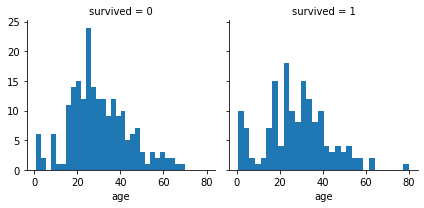

In [ ]:
g = sns.FacetGrid(train_df, col='survived')
g.map(plt.hist, 'age', bins=30);

The `size` parameter has been renamed to `height`; please update your code.


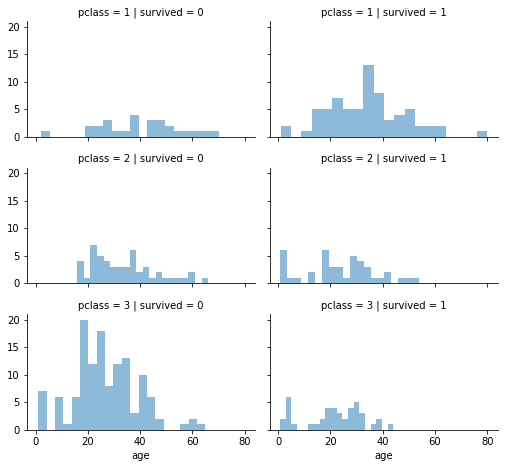

In [ ]:
# 高級クラスで20-30歳でなくなっている人多し
grid = sns.FacetGrid(train_df, col='survived', row='pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'age', alpha=.5, bins=20)
grid.add_legend();

The `size` parameter has been renamed to `height`; please update your code.
Using the barplot function without specifying `order` is likely to produce an incorrect plot.


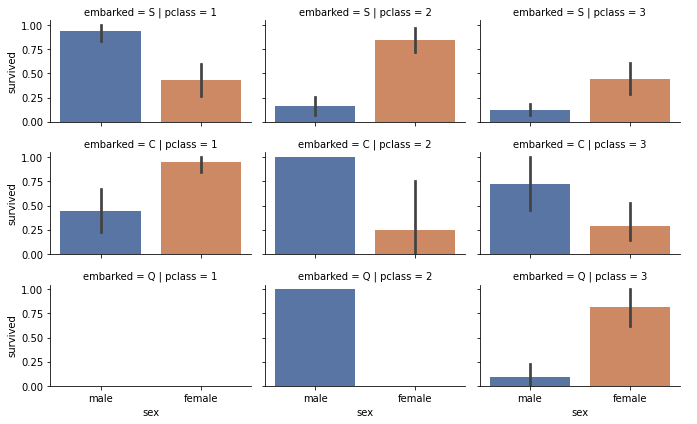

In [ ]:
grid = sns.FacetGrid(train_df, row='embarked', col='pclass', size=2, aspect=1.6)
grid.map(sns.barplot, 'sex',   'survived', palette='deep')
grid.add_legend()

The `size` parameter has been renamed to `height`; please update your code.
Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.


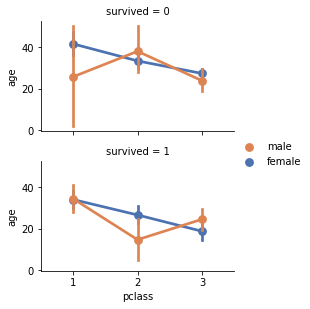

In [ ]:
# 高級クラスで20-30歳でなくなっている人多し

# sns.pointplot(data=train_df, x='pclass', y='age', hue='sex')
grid = sns.FacetGrid(train_df, row='survived',  size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'pclass', 'age', 'sex', palette='deep')
grid.add_legend()

In [ ]:
print(train_df[train_df['pclass'] == 1]["embarked"].value_counts(dropna=False))
print(train_df[train_df['pclass'] == 2]["embarked"].value_counts(dropna=False))
print(train_df[train_df['pclass'] == 3]["embarked"].value_counts(dropna=False))

S      68
C      38
NaN     2
Name: embarked, dtype: int64
S    87
C     9
Q     1
Name: embarked, dtype: int64
S    170
Q     38
C     32
Name: embarked, dtype: int64


The `size` parameter has been renamed to `height`; please update your code.
Using the barplot function without specifying `order` is likely to produce an incorrect plot.


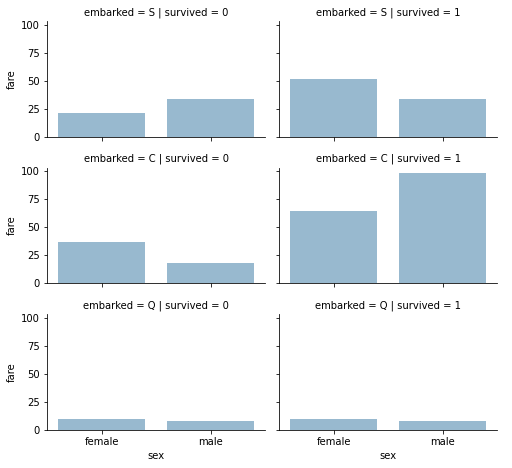

In [ ]:
grid = sns.FacetGrid(train_df, row='embarked', col='survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'sex', 'fare', alpha=.5, ci=None)
grid.add_legend()

The `size` parameter has been renamed to `height`; please update your code.


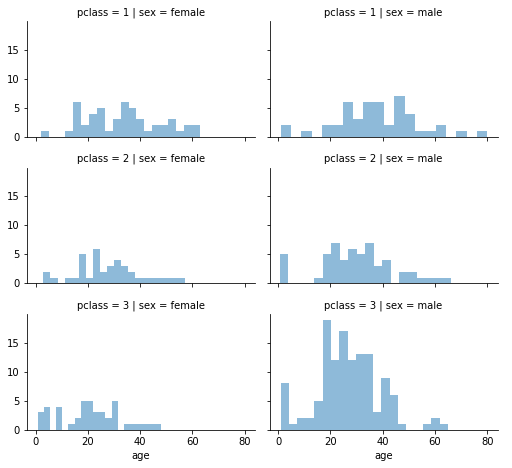

In [ ]:
grid = sns.FacetGrid(train_df, row='pclass', col='sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'age', alpha=.5, bins=20)
grid.add_legend()